In [902]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import matplotlib.gridspec as gridspec

In [903]:
thrust, isp = 100.0, 300.0
src_dir = os.path.dirname("CoolingSystem.ipynb")
docs_path = os.path.abspath(os.path.join(src_dir, '..', 'docs', 'data'))
target_repo = os.path.join(docs_path, f'data_F_{thrust}_ISP_{isp}')
csv_FlowProperties = os.path.join(target_repo, f"data_flow_properties_F_{thrust}_ISP_{isp}.csv")
FlowProperties = pd.read_csv(csv_FlowProperties)


csv_output = os.path.join(target_repo, f"output_sim_F_{thrust}_ISP_{isp}.csv")
Output = pd.read_csv(csv_output)

if any(np.abs(FlowProperties["Mach"]) < 1e-3):
    index = np.argmin(np.abs(FlowProperties["Mach"]))
    
    if 1 <= index < len(FlowProperties["Mach"]) - 1:
        FlowProperties.loc[index, "Mach"] = 0.5 * (
            FlowProperties.loc[index + 1, "Mach"] +
            FlowProperties.loc[index - 1, "Mach"]
        )
        FlowProperties.loc[index, "Speed"] = 0.5 * (
            FlowProperties.loc[index + 1, "Speed"] +
            FlowProperties.loc[index - 1, "Speed"]
        )

docs_path = os.path.abspath(os.path.join(src_dir, '..', 'docs'))
data_HeatTransfert = os.path.join(docs_path, 'data_HeatTransfer')
os.makedirs(data_HeatTransfert, exist_ok=True)  

In [904]:
import numpy as np

def compute_h_g_bartz(mu_g, cp_g, Pr_g, P_g, c_star, Dt, Rc, At, A):
    """Coefficient h_g avec la corrélation de Bartz."""
    return 0.026 * (mu_g**0.2 * cp_g / Pr_g**0.6) * (P_g / c_star)**0.8 * (Dt / Rc**0.1) * (At / A)**0.9

def compute_h_g_dittus_boelter(mu_g, cp_g, k_g, rho_g, u_g, D_h):
    """Coefficient h_g avec la corrélation de Dittus-Boelter."""
    Re = rho_g * u_g * D_h / mu_g
    Pr = cp_g * mu_g / k_g
    return 0.023 * (k_g / D_h) * (Re**0.8) * (Pr**0.4)

def compute_h_conv_vector(x_array, mix_params, Prandtl, FlowProperties, Output):

    T_gas = FlowProperties['Temperature']
    P_gas = FlowProperties['Pressure']
    u_gas = FlowProperties['Speed']
    radius = FlowProperties['radius']
    A = np.pi * radius**2

    At = Output['Section Tuyère'][2]
    Dt = Output['Diamètre Tuyère'][2]
    Rc = Output['Diamètre col'][2]

    mu_mix = mix_params['mu']
    cp_mix = mix_params['cp']
    k_mix = mix_params['k']
    rho_mix = mix_params['rho']

    R_u = 8.314
    M_tot = mix_params['mw']
    gamma = FlowProperties['Gamma'][0]
    R_mix = R_u / M_tot
    c_star = np.sqrt(R_mix * T_gas[0] / gamma) * (2 / (gamma + 1)) ** ((gamma + 1) / (2 * (gamma - 1)))

    h_conv_gas = np.zeros_like(x_array)
    
    for index in range(1, len(x_array)):
        if index <= 99:
            h_conv_gas[index] = compute_h_g_dittus_boelter(mu_mix[index], cp_mix[index], k_mix[index], rho_mix[index], u_gas[index], D_h=2*radius[index])
        else:
            h_conv_gas[index] = compute_h_g_bartz(mu_mix[index], cp_mix[index], Prandtl[index], P_gas[index], c_star, Dt, Rc, At, A[index])

    return h_conv_gas

def compute_h_coolant(mu_c, cp_c, k_c, rho_c, u_c, D_h):
    """
    Calcul du coefficient h côté refroidissement (liquide) via Dittus-Boelter.
    """
    Re = rho_c * u_c * D_h / mu_c
    Pr = cp_c * mu_c / k_c
    return 0.023 * (k_c / D_h) * (Re**0.8) * (Pr**0.4)


In [905]:
T_gas = FlowProperties['Temperature']
P_gas = FlowProperties['Pressure']
x_array = FlowProperties["x"]

mu_co2, k_co2, cp_co2, rho_co2 = np.zeros(shape=T_gas.shape), np.zeros(shape=T_gas.shape), np.zeros(shape=T_gas.shape), np.zeros(shape=T_gas.shape)
mu_h2o, k_h2o, cp_h2o, rho_h20 = np.zeros(shape=T_gas.shape), np.zeros(shape=T_gas.shape), np.zeros(shape=T_gas.shape), np.zeros(shape=T_gas.shape)
mu_n2, k_n2, cp_n2, rho_n2 = np.zeros(shape=T_gas.shape), np.zeros(shape=T_gas.shape), np.zeros(shape=T_gas.shape), np.zeros(shape=T_gas.shape)

for index, temp in enumerate(T_gas):

    # --> CarbonDioxide
    mu_co2[index] = CP.PropsSI('VISCOSITY', 'T', temp, 'P', P_gas[index], 'CarbonDioxide')
    k_co2[index] = CP.PropsSI('CONDUCTIVITY', 'T', temp, 'P', P_gas[index], 'CarbonDioxide')
    cp_co2[index] = CP.PropsSI('CPMASS','T', temp, 'P', P_gas[index], 'CarbonDioxide')
    rho_co2[index] = CP.PropsSI('D','T', temp,'P', P_gas[index], 'CarbonDioxide')

        # --> Water
    mu_h2o[index] = CP.PropsSI('VISCOSITY', 'T', temp, 'P', P_gas[index], 'Water')
    k_h2o[index] = CP.PropsSI('CONDUCTIVITY', 'T', temp, 'P', P_gas[index], 'Water')
    cp_h2o[index] = CP.PropsSI('CPMASS','T', temp, 'P', P_gas[index], 'Water')
    rho_h20[index] = CP.PropsSI('D','T', temp,'P', P_gas[index], 'Water')

        # --> Nitrogen
    mu_n2[index] = CP.PropsSI('VISCOSITY', 'T', temp, 'P', P_gas[index], 'Nitrogen')
    k_n2[index] = CP.PropsSI('CONDUCTIVITY', 'T', temp, 'P', P_gas[index], 'Nitrogen')
    cp_n2[index] = CP.PropsSI('CPMASS','T', temp, 'P', P_gas[index], 'Nitrogen')
    rho_n2[index] = CP.PropsSI('D','T', temp,'P', P_gas[index], 'Nitrogen')

# --> mol number
n_co2, n_h2o, n_n2 = 2, 3, 6
n_tot = n_co2 + n_h2o + n_n2
X_co2, X_h2o, X_n2 = n_co2/n_tot, n_h2o/n_tot, n_n2/n_tot

# --> molecular weight
M_co2, M_h2o, M_n2 = CP.PropsSI("M", "CarbonDioxide"), CP.PropsSI("M", "Water"), CP.PropsSI("M", "Nitrogen")
M_tot = X_co2 * M_co2 + X_h2o * M_h2o + X_n2 * M_n2
Y_co2, Y_h2o, Y_n2 = X_co2 * (M_co2/M_tot), X_h2o * (M_h2o/M_tot), X_n2 * (M_n2/M_tot)

mu_mix, k_mix, cp_mix, rho_mix = np.zeros(shape=T_gas.shape), np.zeros(shape=T_gas.shape), np.zeros(shape=T_gas.shape), np.zeros(shape=T_gas.shape)

R_u = 8.314
for index, temp in enumerate(T_gas):
    mu_mix[index] = X_co2 * mu_co2[index] + X_h2o * mu_h2o[index] + X_n2 * mu_n2[index]
    k_mix[index]  = X_co2 * k_co2[index] + X_h2o * k_h2o[index] + X_n2 * k_n2[index]
    cp_mix[index] = Y_co2 * cp_co2[index] + Y_h2o * cp_h2o[index] + Y_n2 * cp_n2[index]
    rho_mix[index] = P_gas[index] * M_tot / (R_u * temp)

# --> Prandtl number
Prandtl_mix = [(mu * cp) / k for mu, cp, k in zip(mu_mix, cp_mix, k_mix)]

mix_params = {
    'mu': mu_mix,
    'cp': cp_mix,
    'k': k_mix,
    'rho': rho_mix,
    'mw': M_tot
}

h_conv_gas = compute_h_conv_vector(x_array, mix_params, Prandtl_mix, FlowProperties, Output)
if h_conv_gas[0] == 0.0:
    h_conv_gas[0] = h_conv_gas[1]

# cooling system
mu_c2h6o, k_c2h6o, cp_c2h6o, rho_c2h6o = np.zeros(shape=T_gas.shape), np.zeros(shape=T_gas.shape), np.zeros(shape=T_gas.shape), np.zeros(shape=T_gas.shape)

delta_P, P_inj = 2e5, 20e5
P_cooling = np.linspace(P_inj, P_inj - delta_P, len(x_array))
T_inj = 300
T_cooling = np.linspace(T_inj, T_inj, len(x_array))

for index, temp in enumerate(T_gas):
    # --> Ethanol
    mu_c2h6o[index] = CP.PropsSI('VISCOSITY', 'T', T_cooling[index], 'P', P_cooling[index], 'Ethanol')
    k_c2h6o[index] = CP.PropsSI('CONDUCTIVITY', 'T', T_cooling[index], 'P', P_cooling[index], 'Ethanol')
    cp_c2h6o[index] = CP.PropsSI('CPMASS','T', T_cooling[index], 'P', P_cooling[index], 'Ethanol')
    rho_c2h6o[index] = CP.PropsSI('D','T', T_cooling[index],'P', P_cooling[index], 'Ethanol')

# --> Prandtl number
Prandtl_cooling = [(mu * cp) / k for mu, cp, k in zip(mu_c2h6o, cp_c2h6o, k_c2h6o)]
geometry_cooling = {
    "width": 0.002,             # m
    "height": 0.001             # m
}
section_cooling = geometry_cooling['width'] * geometry_cooling['height']
perimeter_cooling = 2 * (geometry_cooling['width'] + geometry_cooling['height'])
diameter_cooling = 4 * (section_cooling/perimeter_cooling)

m_dot_cooling = 1
u_cooling = m_dot_cooling / (rho_c2h6o * section_cooling)
Re_cooling = (rho_c2h6o * u_cooling * diameter_cooling) / mu_c2h6o
h_conv_cooling = np.array([
    0.023 * (k / diameter_cooling) * (Re**0.8) * (Pr**0.4)
    for k, Re, Pr in zip(k_c2h6o, Re_cooling, Prandtl_cooling)
])

In [906]:
def compute_wall_temperatures_detailed(x_array, T_gas, T_cool_inj, h_gas, h_cool, wall_thickness, k_wall,
                                       P_channel, m_dot, cp_gas, cp_cool):
    """
    Compute wall temperatures and gas cooling with an evolving coolant temperature.
    """
    T_wall = np.zeros_like(T_gas)
    T_wall_noflux = np.zeros_like(T_gas)
    T_gas_cooling = np.zeros_like(T_gas)
    T_cool_vector = np.zeros_like(T_gas)
    delta_T_wall = np.zeros_like(T_gas)

    T_cool_vector[0] = T_cool_inj
    dx = np.diff(x_array, prepend=x_array[0])
    eps = 1e-12

    for index in range(len(x_array)):
        hg = h_gas[index] + eps
        hc = h_cool[index] + eps
        tg = T_gas[index]
        tc = T_cool_vector[index]
        cp_g = cp_gas[index]
        cp_c = cp_cool[index]

        # Thermal resistances
        R_conv_gas = 1 / hg
        R_conv_fluid = 1 / hc
        R_wall = wall_thickness / k_wall

        # Wall temperature with cooling
        T_wall[index] = (R_conv_fluid * tg + (R_conv_gas + R_wall) * tc) / (R_conv_gas + R_wall + R_conv_fluid)

        # Wall temperature without cooling
        R_total_noflux = R_conv_gas + R_wall
        T_wall_noflux[index] = (R_wall * tg) / R_total_noflux

        # Heat flux and gas temperature drop
        delta_Q_gas = hg * P_channel * dx[index] * (tg - T_wall[index])
        delta_T_gas = delta_Q_gas / (m_dot * cp_g + eps)
        T_gas_cooling[index] = tg - delta_T_gas

        # Update coolant temperature for next section
        if index < len(x_array) - 1:
            delta_Q_cool = hc * P_channel * dx[index] * (T_wall[index] - tc)
            delta_T_cool = delta_Q_cool / (m_dot * cp_c + eps)
            T_cool_vector[index + 1] = tc + delta_T_cool

        # Track incoherence
        delta_T_wall[index] = T_wall_noflux[index] - T_wall[index]

    # Optional debug
    if np.any(delta_T_wall < -1e-3):
        print(f"! {np.sum(delta_T_wall < -1e-3)} zones where T_wall (cooling) > T_wall (no cooling)")

    return T_wall_noflux, T_wall, T_gas_cooling, T_cool_vector, delta_T_wall


wall_thickness, k_wall = 0.0015, 15

T_wall_noflux, T_wall_flux, T_gas_cooling, T_cool_vector, delta_T_wall = compute_wall_temperatures_detailed(
    x_array=x_array,
    T_gas=T_gas,
    T_cool_inj=T_inj,
    h_gas=h_conv_gas,
    h_cool=h_conv_cooling,
    wall_thickness=wall_thickness,
    k_wall=k_wall,
    P_channel=perimeter_cooling,
    m_dot=FlowProperties['m_dot'][0],
    cp_gas=cp_mix,
    cp_cool=cp_c2h6o
)

! 136 zones where T_wall (cooling) > T_wall (no cooling)


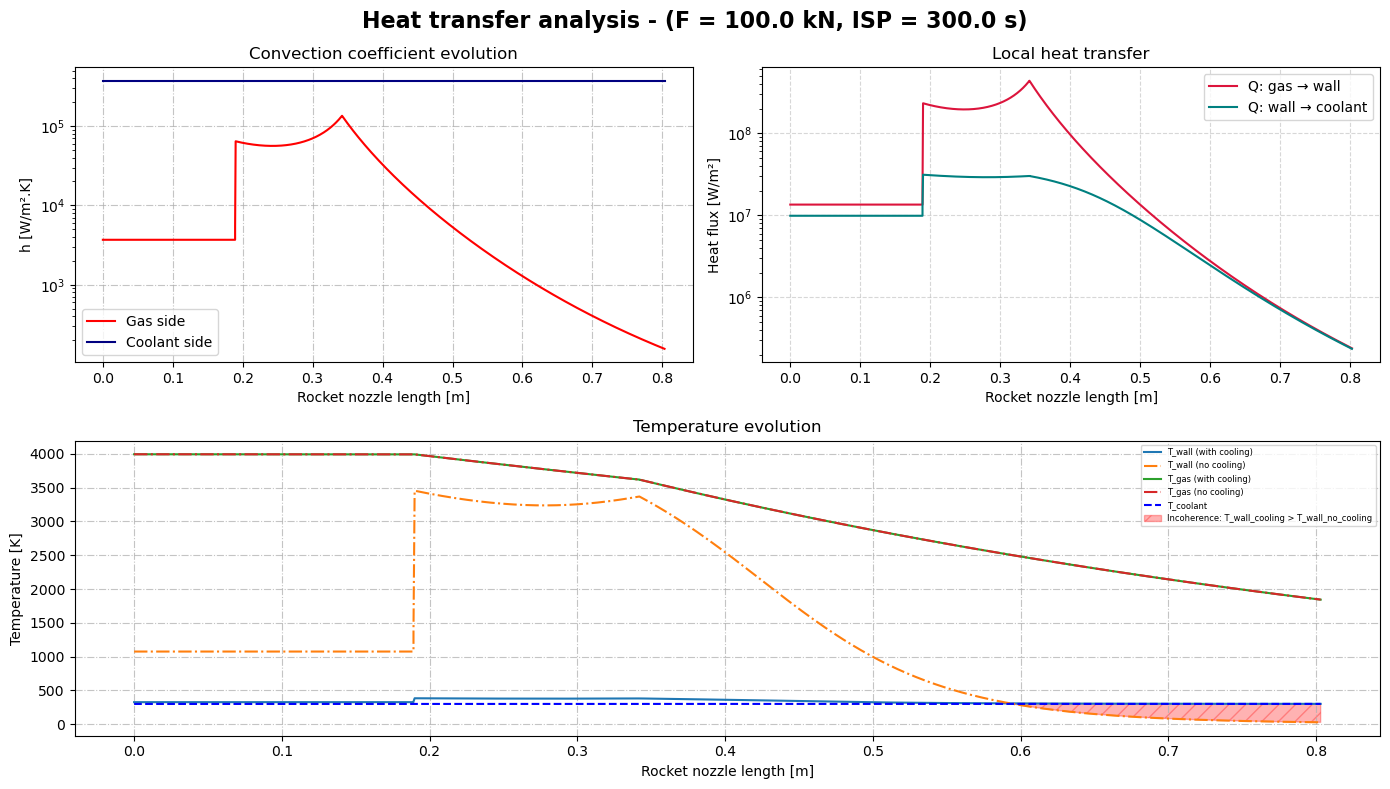

In [907]:
# Recalcul des flux avec T_cool_vector variable
q_gas_wall = h_conv_gas * (T_gas - T_wall_flux)
q_wall_coolant = h_conv_cooling * (T_wall_flux - T_cool_vector)

fig = plt.figure(figsize=(14, 8))
fig.suptitle(f"Heat transfer analysis - (F = {thrust} kN, ISP = {isp} s)", fontsize=16, fontweight='bold')
gs = gridspec.GridSpec(2, 2)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, :])

# ---- Convection coefficients ----
ax0.set_title("Convection coefficient evolution")
ax0.plot(x_array, h_conv_gas, color='red', label='Gas side')
ax0.plot(x_array, h_conv_cooling, color='navy', label='Coolant side')
ax0.grid(True, alpha=0.75, linestyle='-.')
ax0.set_yscale('log')
ax0.set_xlabel("Rocket nozzle length [m]")
ax0.set_ylabel("h [W/m².K]")
ax0.legend()

# ---- Heat fluxes ----
ax1.set_title("Local heat transfer")
ax1.plot(x_array, q_gas_wall, label="Q: gas → wall", color='crimson')
ax1.plot(x_array, q_wall_coolant, label="Q: wall → coolant", color='teal')
ax1.set_xlabel("Rocket nozzle length [m]")
ax1.set_ylabel("Heat flux [W/m²]")
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.5)

# ---- Temperature evolution ----
incoherent_zone = T_wall_flux > T_wall_noflux
ax2.set_title("Temperature evolution")
ax2.plot(x_array, T_wall_flux, label='T_wall (with cooling)')
ax2.plot(x_array, T_wall_noflux, linestyle='-.', label='T_wall (no cooling)')
ax2.plot(x_array, T_gas_cooling, label='T_gas (with cooling)')
ax2.plot(x_array, T_gas, linestyle='-.', label='T_gas (no cooling)')
ax2.plot(x_array, T_cool_vector, label='T_coolant', color='blue', linestyle='--')

# Incoherent zone fill
ax2.fill_between(x_array, T_wall_flux, T_wall_noflux, where=incoherent_zone,
                 hatch='//', color='red', alpha=0.3,
                 label='Incoherence: T_wall_cooling > T_wall_no_cooling')

ax2.grid(True, linestyle='-.', alpha=0.75)
ax2.set_ylabel("Temperature [K]")
ax2.set_xlabel("Rocket nozzle length [m]")
ax2.legend(loc='upper right', fontsize=6)

plt.tight_layout()

png_name = f"HeatTransferAnalyse_F_{thrust}_ISP_{isp}.png"
plt.savefig(os.path.join(data_HeatTransfert, png_name), dpi=300)